In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
X_train = []
Y_train = []
label_to_y = dict()
with open("/content/drive/MyDrive/Colab Notebooks/data/TRAIN_FILE.txt") as f:
    for idx, l in enumerate(f):
        l = l.strip()
        if idx % 4 == 0:
            ID, sentence = l.split("\t")
            sentence = sentence[1:-1]
            sentence = sentence.replace('<e1>', 'xxxxxxxxxe1xxxxxxxxx ')
            sentence = sentence.replace('<e2>', 'xxxxxxxxxe2xxxxxxxxx ')
            sentence = sentence.replace('</e1>', ' ssssssssse1sssssssss')
            sentence = sentence.replace('</e2>', ' ssssssssse2sssssssss')
            X_train.append(sentence)
        elif idx % 4 == 1:
            label = l
            if label not in label_to_y:
                label_to_y[label] = len(label_to_y)
            Y_train.append(label_to_y[label])
        else:
            pass

In [ ]:
label_to_y

{'Component-Whole(e2,e1)': 0,
 'Other': 1,
 'Instrument-Agency(e2,e1)': 2,
 'Member-Collection(e1,e2)': 3,
 'Cause-Effect(e2,e1)': 4,
 'Entity-Destination(e1,e2)': 5,
 'Content-Container(e1,e2)': 6,
 'Message-Topic(e1,e2)': 7,
 'Product-Producer(e2,e1)': 8,
 'Member-Collection(e2,e1)': 9,
 'Entity-Origin(e1,e2)': 10,
 'Cause-Effect(e1,e2)': 11,
 'Component-Whole(e1,e2)': 12,
 'Message-Topic(e2,e1)': 13,
 'Product-Producer(e1,e2)': 14,
 'Entity-Origin(e2,e1)': 15,
 'Content-Container(e2,e1)': 16,
 'Instrument-Agency(e1,e2)': 17,
 'Entity-Destination(e2,e1)': 18}

In [ ]:
CLASS_TO_LABEL = {'Component-Whole(e2,e1)': 0,
 'Other': 1,
 'Instrument-Agency(e2,e1)': 2,
 'Member-Collection(e1,e2)': 3,
 'Cause-Effect(e2,e1)': 4,
 'Entity-Destination(e1,e2)': 5,
 'Content-Container(e1,e2)': 6,
 'Message-Topic(e1,e2)': 7,
 'Product-Producer(e2,e1)': 8,
 'Member-Collection(e2,e1)': 9,
 'Entity-Origin(e1,e2)': 10,
 'Cause-Effect(e1,e2)': 11,
 'Component-Whole(e1,e2)': 12,
 'Message-Topic(e2,e1)': 13,
 'Product-Producer(e1,e2)': 14,
 'Entity-Origin(e2,e1)': 15,
 'Content-Container(e2,e1)': 16,
 'Instrument-Agency(e1,e2)': 17,
 'Entity-Destination(e2,e1)': 18}

In [ ]:
    X_test = []
    ID_test = []
    with open("/content/drive/MyDrive/Colab Notebooks/data/TEST_FILE.txt") as f:
        for l in f:
            ID, sentence = l.strip().split("\t")
            sentence = sentence[1:-1]
            sentence = sentence.replace('<e1>', 'xxxxxxxxxe1xxxxxxxxx ')
            sentence = sentence.replace('<e2>', 'xxxxxxxxxe2xxxxxxxxx ')
            sentence = sentence.replace('</e1>', ' ssssssssse1sssssssss')
            sentence = sentence.replace('</e2>', ' ssssssssse2sssssssss')
            ID_test.append(ID)
            X_test.append(sentence)

In [ ]:
Y_test = []
with open("/content/drive/MyDrive/Colab Notebooks/data/answer_key_e1e2.txt") as f:
    for l in f:
        ID, sentence = l.strip().split("\t")
        Y_test.append(sentence)

In [ ]:

criterion = torch.nn.CrossEntropyLoss()

# Setting the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading and tokenizing the data for bert-base-uncased
tokenizer_base = BertTokenizer.from_pretrained('bert-base-uncased')

# Loading and tokenizing the data for bert-large-uncased
tokenizer_large = BertTokenizer.from_pretrained('bert-large-uncased')

# Tokenize the data
def tokenize_data(sentences, labels=None, max_len=128, tokenizer=None):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        encoding = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])

    if labels is not None:
        return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0), torch.tensor(labels)
    else:
        return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

# # Load data from text files
test_data =  pd.DataFrame({'sentence':X_test,'label':Y_test})
train_data = pd.DataFrame({'sentence':X_train,'label':Y_train})



# Converting labels to numeric values for training data
label_mapping_train = {label: idx for idx, label in enumerate(train_data['label'].unique())}
# train_data['label'] = train_data['label'].map(CLASS_TO_LABEL)
# label_mapping_train = {label: idx for idx, label in enumerate(Y_train.unique())}
# Y_train = Y_train.map(label_mapping_train)

# Split the data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Reseting the index for all datasets
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
# Tokenizing the data for bert-base-uncased
train_inputs_base, train_masks_base, train_labels_base = tokenize_data(train_data['sentence'], train_data['label'], tokenizer=tokenizer_base)
val_inputs_base, val_masks_base, val_labels_base = tokenize_data(val_data['sentence'], val_data['label'], tokenizer=tokenizer_base)
test_sentences_base = test_data['sentence'].tolist()
# Tokenize the test data without labels for bert-base-uncased
test_inputs_base, test_masks_base = tokenize_data(test_sentences_base, tokenizer=tokenizer_base)


# Tokenizing the data for bert-large-uncased
train_inputs_large, train_masks_large, train_labels_large = tokenize_data(train_data['sentence'], train_data['label'], tokenizer=tokenizer_large)
val_inputs_large, val_masks_large, val_labels_large = tokenize_data(val_data['sentence'], val_data['label'], tokenizer=tokenizer_large)
# Extracting only the sentences from the test_data['sentence'] column for bert-large-uncased
test_sentences_large = test_data['sentence'].tolist()

# Tokenize the test data without labels for bert-large-uncased
test_inputs_large, test_masks_large = tokenize_data(test_sentences_large, tokenizer=tokenizer_large)

#  DataLoader for training, validation, and test sets for bert-base-uncased
batch_size = 8
train_dataset_base = TensorDataset(train_inputs_base, train_masks_base, train_labels_base)
val_dataset_base = TensorDataset(val_inputs_base, val_masks_base, val_labels_base)
test_dataset_base = TensorDataset(test_inputs_base, test_masks_base)

train_dataloader_base = DataLoader(train_dataset_base, batch_size=batch_size, shuffle=True)
val_dataloader_base = DataLoader(val_dataset_base, batch_size=batch_size, shuffle=False)
test_dataloader_base = DataLoader(test_dataset_base, batch_size=batch_size, shuffle=False)

# DataLoader for training, validation, and test sets for bert-large-uncased
train_dataset_large = TensorDataset(train_inputs_large, train_masks_large, train_labels_large)
val_dataset_large = TensorDataset(val_inputs_large, val_masks_large, val_labels_large)
test_dataset_large = TensorDataset(test_inputs_large, test_masks_large)

train_dataloader_large = DataLoader(train_dataset_large, batch_size=batch_size, shuffle=True)
val_dataloader_large = DataLoader(val_dataset_large, batch_size=batch_size, shuffle=False)
test_dataloader_large = DataLoader(test_dataset_large, batch_size=batch_size, shuffle=False)

# Loading pre-trained BERT models for sequence classification
model_base = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=19)
model_large = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=19)

models = {'bert-base-uncased': model_base, 'bert-large-uncased': model_large}

# hyperparameters
window_size = 2
gamma = 2
alpha = [1, 4, 2, 14, 3, 4, 4, 4, 9, 3, 9, 1, 100, 3, 3, 14, 2, 3, 9]

# Training loop
epochs = 5
for model_name, model in models.items():
    model.to(device)
    # Defining optimizer and learning rate scheduler with specified hyperparameters
    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=5e-3)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_dataloader_base:
            inputs, masks, labels = batch
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, attention_mask=masks, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        average_loss = total_loss / len(train_dataloader_base)
        print(f"{model_name} - Epoch {epoch + 1}/{epochs}, Average Training Loss: {average_loss}")


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


bert-base-uncased - Epoch 1/5, Average Training Loss: 1.723539135158062
bert-base-uncased - Epoch 2/5, Average Training Loss: 0.6576218687463552
bert-base-uncased - Epoch 3/5, Average Training Loss: 0.3818899087200407
bert-base-uncased - Epoch 4/5, Average Training Loss: 0.22997494619630743
bert-base-uncased - Epoch 5/5, Average Training Loss: 0.14828315204184037


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


bert-large-uncased - Epoch 1/5, Average Training Loss: 1.4368710809294134
bert-large-uncased - Epoch 2/5, Average Training Loss: 0.5496952820708976
bert-large-uncased - Epoch 3/5, Average Training Loss: 0.32951422710873884
bert-large-uncased - Epoch 4/5, Average Training Loss: 0.21852291733863238
bert-large-uncased - Epoch 5/5, Average Training Loss: 0.1470411761561263


In [ ]:
model_base.save_pretrained("/content/drive/MyDrive/Colab Notebooks/models/bert_base_trained_model")
model_large.save_pretrained("/content/drive/MyDrive/Colab Notebooks/models/bert_large_trained_model")

In [ ]:
# Validation loop
val_predictions = {model_name: [] for model_name in models}
val_true_labels = {model_name: [] for model_name in models}

for model_name, model in models.items():
    model.eval()

    with torch.no_grad():
        for batch in val_dataloader_base if model_name == 'bert-base-uncased' else val_dataloader_large:
            inputs, masks, labels = batch
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

            outputs = model(inputs, attention_mask=masks)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            val_predictions[model_name].extend(predictions.cpu().numpy())
            val_true_labels[model_name].extend(labels.cpu().numpy())

# Calculating accuracy on the validation set for bert-base-uncased
val_accuracy_base = accuracy_score(val_true_labels['bert-base-uncased'], val_predictions['bert-base-uncased'])
print(f"Validation Accuracy for bert-base-uncased: {val_accuracy_base}")

# Calculating accuracy on the validation set for bert-large-uncased
val_accuracy_large = accuracy_score(val_true_labels['bert-large-uncased'], val_predictions['bert-large-uncased'])
print(f"Validation Accuracy for bert-large-uncased: {val_accuracy_large}")


Validation Accuracy for bert-base-uncased: 0.828125
Validation Accuracy for bert-large-uncased: 0.849375


In [ ]:
# Test loop for both models
test_predictions = {model_name: [] for model_name in models}

for model_name, model in models.items():
    model.eval()
    test_dataloader = test_dataloader_base if model_name == 'bert-base-uncased' else test_dataloader_large

    with torch.no_grad():
        for batch in test_dataloader:
            inputs, masks = batch
            inputs, masks = inputs.to(device), masks.to(device)

            outputs = model(inputs, attention_mask=masks)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            test_predictions[model_name].extend(predictions.cpu().numpy())

# test_predictions contains the predicted labels for both models on the test data
print("Test Predictions for bert-base-uncased:", test_predictions['bert-base-uncased'])
print("Test Predictions for bert-large-uncased:", test_predictions['bert-large-uncased'])

Test Predictions for bert-base-uncased: [7, 8, 2, 5, 4, 12, 1, 9, 12, 7, 5, 14, 5, 1, 10, 10, 5, 1, 9, 17, 7, 6, 1, 3, 15, 14, 1, 1, 12, 10, 11, 7, 12, 1, 12, 0, 9, 1, 9, 4, 15, 0, 1, 5, 10, 6, 12, 6, 7, 1, 5, 1, 9, 1, 11, 10, 5, 11, 1, 0, 15, 1, 2, 3, 5, 1, 1, 1, 7, 14, 1, 10, 4, 10, 1, 1, 1, 2, 5, 8, 12, 12, 11, 12, 1, 2, 7, 8, 15, 7, 1, 8, 6, 1, 1, 5, 7, 12, 5, 1, 7, 2, 10, 7, 4, 7, 4, 11, 0, 9, 1, 6, 1, 8, 1, 4, 14, 1, 9, 0, 5, 2, 10, 1, 7, 15, 1, 1, 1, 6, 1, 7, 12, 8, 6, 1, 12, 9, 10, 9, 2, 1, 1, 10, 9, 2, 6, 13, 1, 8, 14, 9, 9, 7, 7, 8, 12, 1, 11, 13, 7, 10, 10, 8, 5, 6, 9, 9, 10, 2, 5, 3, 10, 1, 4, 14, 5, 10, 2, 7, 5, 6, 2, 8, 6, 9, 5, 1, 13, 1, 11, 1, 7, 9, 13, 1, 15, 5, 5, 14, 12, 6, 3, 4, 5, 12, 0, 16, 9, 9, 12, 10, 5, 2, 1, 16, 6, 9, 4, 1, 1, 1, 7, 13, 1, 1, 6, 9, 14, 1, 10, 9, 1, 4, 15, 4, 1, 12, 11, 4, 14, 6, 12, 1, 14, 8, 1, 12, 10, 5, 12, 1, 11, 12, 1, 1, 4, 14, 0, 2, 7, 5, 15, 13, 4, 5, 7, 0, 1, 1, 1, 1, 13, 9, 1, 5, 7, 2, 8, 14, 3, 5, 3, 1, 7, 6, 9, 4, 1, 7, 6, 7, 12, 

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculating precision, recall, and F1 for both models
precision_base, recall_base, f1_base, _ = precision_recall_fscore_support(val_true_labels['bert-base-uncased'], val_predictions['bert-base-uncased'], average='macro')
precision_large, recall_large, f1_large, _ = precision_recall_fscore_support(val_true_labels['bert-large-uncased'], val_predictions['bert-large-uncased'], average='macro')

# Print precision, recall, and F1 values
print("Metrics for bert-base-uncased:")
print(f"Precison: {precision_base}")
print(f"Recall: {recall_base}")
print(f"F1: {f1_base}")
print("\n")

print("Metrics for bert-large-uncased:")
print(f"Precison: {precision_large}")
print(f"Recall: {recall_large}")
print(f"F1: {f1_large}")


Metrics for bert-base-uncased:
Precison: 0.8517581027977417
Recall: 0.8131411055138579
F1: 0.8291281289506093


Metrics for bert-large-uncased:
Precison: 0.8831228467196678
Recall: 0.8310743634439279
F1: 0.851843894491545


In [ ]:
from sklearn.metrics import balanced_accuracy_score

true_labels_base = val_true_labels['bert-base-uncased']
predicted_labels_base = val_predictions['bert-base-uncased']

true_labels_large = val_true_labels['bert-large-uncased']
predicted_labels_large = val_predictions['bert-large-uncased']

# Calculating balanced accuracy for bert-base-uncased
balanced_accuracy_base = balanced_accuracy_score(true_labels_base, predicted_labels_base)
print(f"Balanced Accuracy for bert-base-uncased: {balanced_accuracy_base}")

# Calculating balanced accuracy for bert-large-uncased
balanced_accuracy_large = balanced_accuracy_score(true_labels_large, predicted_labels_large)
print(f"Balanced Accuracy for bert-large-uncased: {balanced_accuracy_large}")


Balanced Accuracy for bert-base-uncased: 0.8131411055138579
Balanced Accuracy for bert-large-uncased: 0.8310743634439279


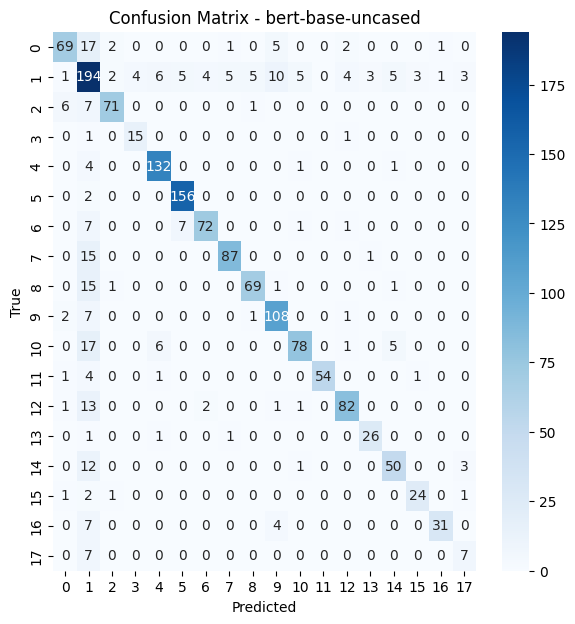

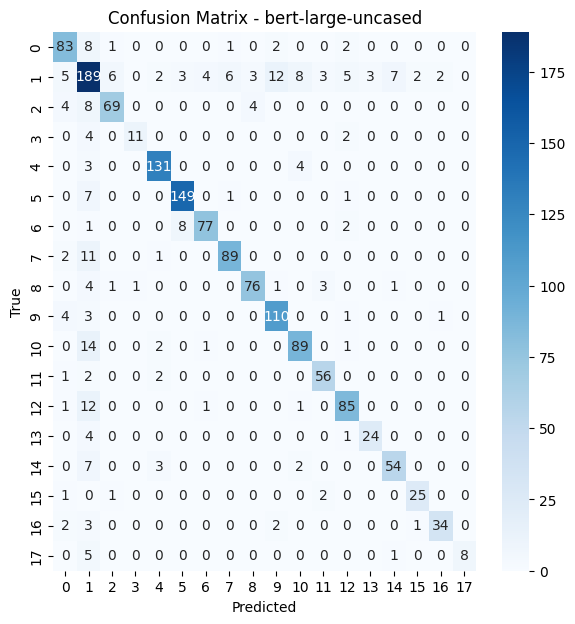

In [ ]:
# Calculating confusion matrices for both models
conf_matrix_base = confusion_matrix(val_true_labels['bert-base-uncased'], val_predictions['bert-base-uncased'])
conf_matrix_large = confusion_matrix(val_true_labels['bert-large-uncased'], val_predictions['bert-large-uncased'])

# Plot confusion matrices
labels = sorted(set(val_true_labels['bert-base-uncased']+ val_predictions['bert-base-uncased']))

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_base, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - bert-base-uncased")
plt.xlabel("Predicted")
plt.ylabel("True")

labels = sorted(set(val_true_labels['bert-large-uncased']+ val_predictions['bert-large-uncased']))

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_large, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - bert-large-uncased")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

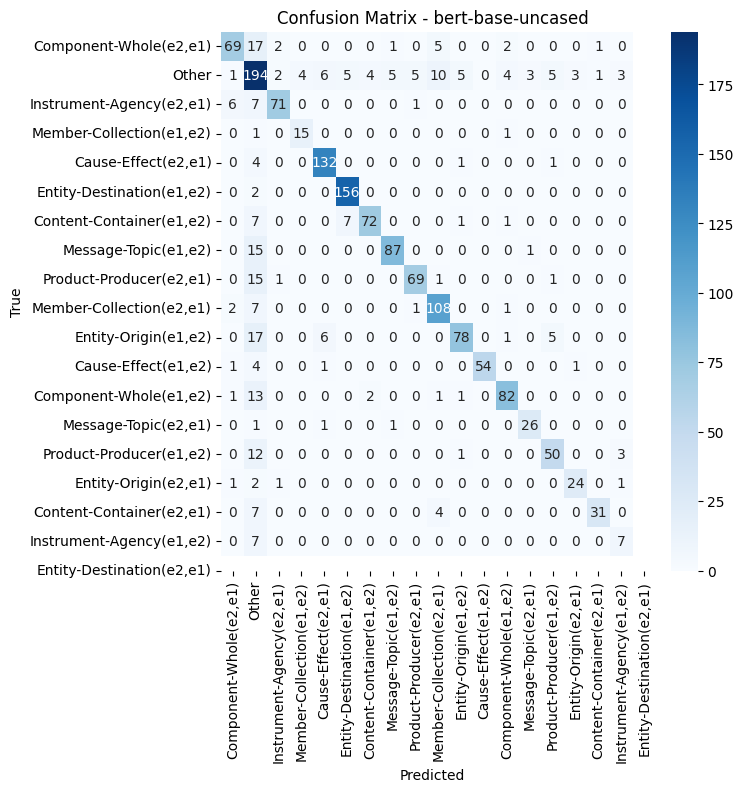

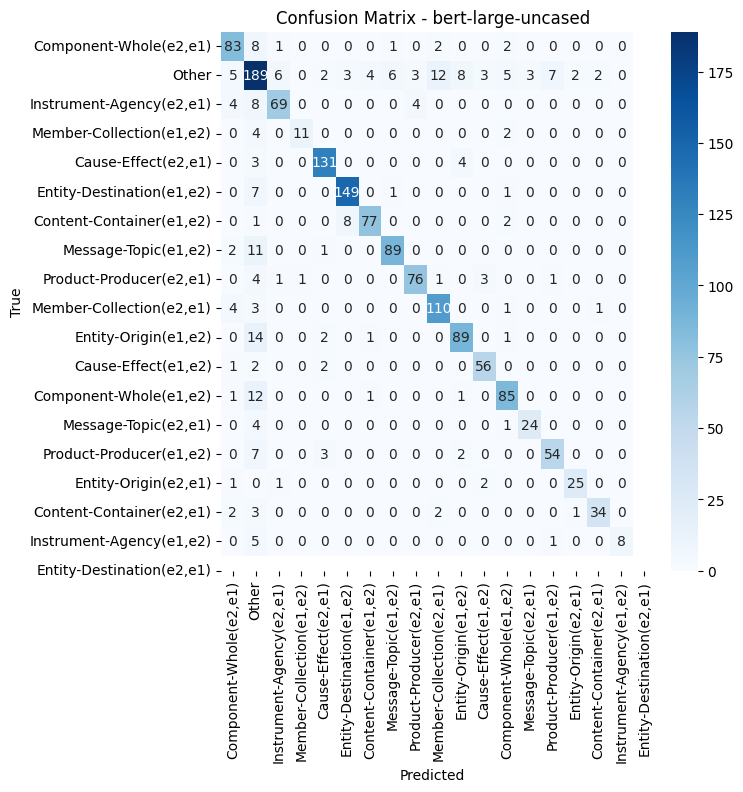

In [ ]:
# Calculating confusion matrices for both models
conf_matrix_base = confusion_matrix(val_true_labels['bert-base-uncased'], val_predictions['bert-base-uncased'], labels=labels)
conf_matrix_large = confusion_matrix(val_true_labels['bert-large-uncased'], val_predictions['bert-large-uncased'], labels=labels)

# Plot confusion matrices by class
class_names = [key for key in CLASS_TO_LABEL.keys()]

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_base, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - bert-base-uncased")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("/content/drive/MyDrive/Colab Notebooks/results/confusion_matrix_base.png")
plt.show()
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_large, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - bert-large-uncased")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("/content/drive/MyDrive/Colab Notebooks/results/confusion_matrix_large.png")
plt.show()

In [ ]:
original_pred = [label_to_y[label] for label in Y_test]

In [ ]:
import numpy as np
type(np.array(original_pred))

numpy.ndarray

In [ ]:
# CLASS_TO_LABEL = {'Component-Whole(e2,e1)': 0,
#  'Other': 1,
#  'Instrument-Agency(e2,e1)': 2,
#  'Member-Collection(e1,e2)': 3,
#  'Cause-Effect(e2,e1)': 4,
#  'Entity-Destination(e1,e2)': 5,
#  'Content-Container(e1,e2)': 6,
#  'Message-Topic(e1,e2)': 7,
#  'Product-Producer(e2,e1)': 8,
#  'Member-Collection(e2,e1)': 9,
#  'Entity-Origin(e1,e2)': 10,
#  'Cause-Effect(e1,e2)': 11,
#  'Component-Whole(e1,e2)': 12,
#  'Message-Topic(e2,e1)': 13,
#  'Product-Producer(e1,e2)': 14,
#  'Entity-Origin(e2,e1)': 15,
#  'Content-Container(e2,e1)': 16,
#  'Instrument-Agency(e1,e2)': 17,
#  'Entity-Destination(e2,e1)': 18}



# Convert original_pred to a DataFrame for easy manipulation
df = pd.DataFrame({'original_pred': test_predictions['bert-base-uncased']})

# Reverse mapping from label to class
LABEL_TO_CLASS = {v: k for k, v in CLASS_TO_LABEL.items()}

# Map the original_pred to class names
df['class_name'] = df['original_pred'].map(LABEL_TO_CLASS)

# Create a new DataFrame with the desired format
result_df = pd.DataFrame({
    'ID': range(8001, 8001 + len(df)),
    'Class-Name': df['class_name']
})

# Saving the result to a text file
result_df.to_csv('/content/drive/MyDrive/Colab Notebooks/results/output_base.txt', sep='\t', index=False, header=False, columns=['ID', 'Class-Name'])


In [ ]:
# Load the content of 'output.txt' and 'answer_key_e1e2'
output_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/results/output_base.txt', sep='\t', header=None, names=['ID', 'Class-Name'])
answer_key_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/answer_key_e1e2.txt', sep='\t', header=None, names=['ID', 'Class-Name'])

# Merge the two DataFrames on the 'ID' column
merged_df = pd.merge(output_df, answer_key_df, on='ID', suffixes=('_pred', '_true'))

# Calculate accuracy
accuracy = (merged_df['Class-Name_pred'] == merged_df['Class-Name_true']).mean()

print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 82.66%


In [ ]:
# CLASS_TO_LABEL = {'Component-Whole(e2,e1)': 0,
#  'Other': 1,
#  'Instrument-Agency(e2,e1)': 2,
#  'Member-Collection(e1,e2)': 3,
#  'Cause-Effect(e2,e1)': 4,
#  'Entity-Destination(e1,e2)': 5,
#  'Content-Container(e1,e2)': 6,
#  'Message-Topic(e1,e2)': 7,
#  'Product-Producer(e2,e1)': 8,
#  'Member-Collection(e2,e1)': 9,
#  'Entity-Origin(e1,e2)': 10,
#  'Cause-Effect(e1,e2)': 11,
#  'Component-Whole(e1,e2)': 12,
#  'Message-Topic(e2,e1)': 13,
#  'Product-Producer(e1,e2)': 14,
#  'Entity-Origin(e2,e1)': 15,
#  'Content-Container(e2,e1)': 16,
#  'Instrument-Agency(e1,e2)': 17,
#  'Entity-Destination(e2,e1)': 18}


# Convert original_pred to a DataFrame for easy manipulation
df = pd.DataFrame({'original_pred': test_predictions['bert-large-uncased']})

# Reverse mapping from label to class
LABEL_TO_CLASS = {v: k for k, v in CLASS_TO_LABEL.items()}

# Map the original_pred to class names
df['class_name'] = df['original_pred'].map(LABEL_TO_CLASS)

# Create a new DataFrame with the desired format
result_df = pd.DataFrame({
    'ID': range(8001, 8001 + len(df)),
    'Class-Name': df['class_name']
})

# Saving the result to a text file
result_df.to_csv('/content/drive/MyDrive/Colab Notebooks/results/output_large.txt', sep='\t', index=False, header=False, columns=['ID', 'Class-Name'])


In [ ]:
# Load the content of 'output.txt' and 'answer_key_e1e2.txt'
output_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/results/output_large.txt', sep='\t', header=None, names=['ID', 'Class-Name'])
answer_key_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/answer_key_e1e2.txt', sep='\t', header=None, names=['ID', 'Class-Name'])

# Merge the two DataFrames on the 'ID' column
merged_df = pd.merge(output_df, answer_key_df, on='ID', suffixes=('_pred', '_true'))

# Calculate accuracy
accuracy = (merged_df['Class-Name_pred'] == merged_df['Class-Name_true']).mean()

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 83.33%
